# Okavango_Scenario

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import matplotlib.patches as patches
from matplotlib.dates import date2num
import matplotlib.dates as mdates
from hydroeval import evaluator, nse, rmse, pbias
from pyemu.pst.pst_utils import SFMT,IFMT,FFMT

flopy is installed in C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\flopy


In [18]:
from swatmf_pkgs import swatmf_viz
import itertools

# Set Path

In [2]:
wd_base = "D:/Projects/Watersheds/Okavango/scenarios/okvg_swatmf_calibrated_base"
wd_base_new = "D:/Projects/Watersheds/Okavango/scenarios/okvg_swatmf_calibrated_base_new"
# os.chdir(wd)



# Create Dataframe from output.rch

In [27]:
sub_number= 225

## BASE

In [28]:
df_org = pd.read_csv(
                    os.path.join(wd_base, "output.rch"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, 6],
                    names=["date", "filter", "streamflow_sim"],
                    index_col=0)

df = df_org.loc[sub_number]
df = df[df["filter"] < 13]
df.index = pd.date_range('1/1/2003', periods=len(df.streamflow_sim), freq="M")
df.rename(columns = {'streamflow_sim':'base_{}'.format(sub_number)}, inplace = True)
base_df = df.drop('filter', axis=1)

In [29]:
df_new = pd.read_csv(
                    os.path.join(wd_base_new, "output.rch"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, 6],
                    names=["date", "filter", "streamflow_sim"],
                    index_col=0)

df = df_org.loc[sub_number]
df = df[df["filter"] < 13]
df.index = pd.date_range('1/1/2003', periods=len(df.streamflow_sim), freq="M")
df.rename(columns = {'streamflow_sim':'new_{}'.format(sub_number)}, inplace = True)
new_df = df.drop('filter', axis=1)


In [30]:
dff =  pd.concat([base_df.iloc[:, 0], new_df.iloc[:, 0]], axis=1)
dff

,base_225,new_225
2003-01-31,183.10,183.10
2003-02-28,518.80,518.80
2003-03-31,514.20,514.20
2003-04-30,400.50,400.50
2003-05-31,367.80,367.80
...,...,...
2019-08-31,31.87,31.87
2019-09-30,18.28,18.28
2019-10-31,13.40,13.40
2019-11-30,29.13,29.13


In [31]:
str_obd = pd.read_csv(
                    os.path.join(wd_base, 'streamflow.obd'),
                    sep=r'\s+', index_col=0, header=0,
                    parse_dates=True, delimiter="\t",
                    na_values=[-999, ""]
                    )
str_obd

,sub_225_dirico,sub_240_mohembo
date,,
2002-07-31,43.60,179.44
2002-08-31,31.79,152.58
2002-09-30,29.80,129.19
2002-10-31,49.47,106.57
2002-11-30,64.83,100.52
...,...,...
2020-02-29,NaN,366.05
2020-03-31,NaN,603.31
2020-04-30,NaN,719.03


In [32]:
nams = []
nses = []
rmses = []
pbiases = []
rsquareds = []
for i in range(len(dff.columns)):
    df =  pd.concat([dff.iloc[:, i], str_obd.iloc[:, 0]], axis=1)
    nse, rmse, pbias, rsquared = swatmf_viz.get_stats(df)
    nams.append(dff.columns[i])
    nses.append(nse[0])
    rmses.append(rmse[0])
    pbiases.append(pbias[0])
    rsquareds.append(rsquared)

In [33]:
stat_df = pd.DataFrame(
    np.column_stack([nams, nses, rmses, pbiases, rsquareds]),
    columns=['Scenario Name', 'NSE', 'RMSE', 'PBIAS', 'R-Squared'])
stat_df = stat_df.sort_values(by=['NSE'], ascending=False)
stat_df = stat_df.set_index('Scenario Name')
stat_df = stat_df.astype(float).round(3)
stat_df

,NSE,RMSE,PBIAS,R-Squared
Scenario Name,,,,
base_225,0.523,156.449,-2.664,0.595
new_225,0.523,156.449,-2.664,0.595


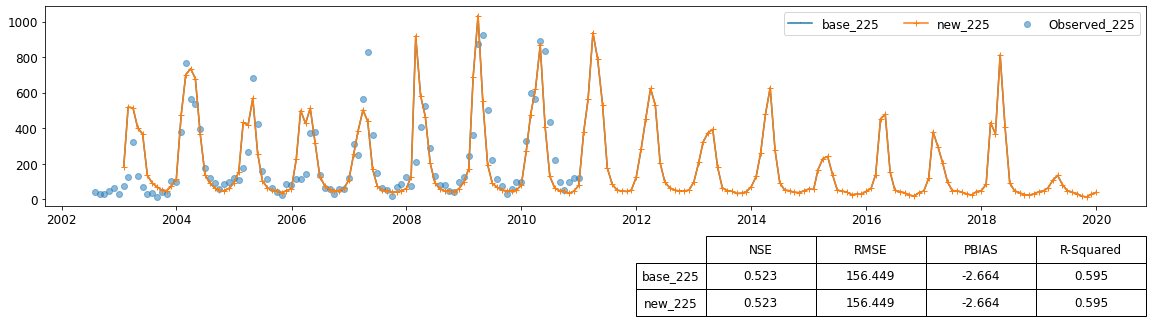

In [34]:
f, ax = plt.subplots(figsize=(16, 6))
marker = itertools.cycle((',', '+', '.', 'o', '*', 'v', '^', '<', '>',))
for i in range(len(dff.columns)):
    ax.plot(dff.index, dff.iloc[:, i], marker = next(marker), label=dff.columns[i])

ax.scatter(str_obd.index, str_obd.iloc[:, 0], alpha=0.5, label='Observed_225')
ax.tick_params(axis='both', labelsize=12)
lines, labels = f.axes[0].get_legend_handles_labels()
f.tight_layout()
ax.legend(
    lines, labels, ncol=3,
    # bbox_to_anchor=(0, 0.202),
    fontsize=12,
    # loc = 'lower left'
    )

# ax.legend(scn_df.columns.tolist(), fontsize=12, ncol=4)

tb = plt.table(
        cellText=stat_df.values,
        colWidths = [0.1]*len(stat_df.columns),
        rowLabels=stat_df.index,
        colLabels=stat_df.columns,
        cellLoc = 'center', rowLoc = 'center',
        bbox = [0.6, -0.55, 0.4, 0.4])
tb.auto_set_font_size(False)
tb.set_fontsize(12)
tb.scale(1, 2)
plt.tight_layout()
plt.savefig(os.path.join('comp_225.png'), dpi=300, bbox_inches="tight")
plt.show()